# ASPDNet experiments
This file contains experiments for my adaptation of ASPDNet. To access GPUs/TPUs, I ran this file in Google Colaboratory.

## Setup
To pull from the GitHub repository in Colab:
```
%cd drive/MyDrive/Conservation\ Research/Code/counting-cranes
!git add .
!git stash
!git pull
```
----

In [1]:
#Mounting Google Drive...
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Will have to restart runtime after running this cell!
!pip install -r "/content/drive/MyDrive/Conservation Research/Code/counting-cranes/requirements.txt"

     |████████████████████████████████| 804.1MB 22kB/s 
     |████████████████████████████████| 17.4MB 34kB/s 
     |████████████████████████████████| 7.1MB 18.1MB/s 
     |████████████████████████████████| 2.2MB 40.4MB/s 
     |████████████████████████████████| 17.4MB 205kB/s 
     |████████████████████████████████| 102kB 15.3MB/s 
     |████████████████████████████████| 15.3MB 202kB/s 
     |████████████████████████████████| 11.6MB 217kB/s 
     |████████████████████████████████| 808kB 48.1MB/s 
     |████████████████████████████████| 8.3MB 28.9MB/s 
     |████████████████████████████████| 27.4MB 110kB/s 
     |████████████████████████████████| 51.0MB 60kB/s 
     |████████████████████████████████| 38.2MB 62kB/s 
     |████████████████████████████████| 829kB 57.1MB/s 
     |████████████████████████████████| 122kB 53.1MB/s 
     |████████████████████████████████| 235kB 59.1MB/s 
     |████████████████████████████████| 10.6MB 185kB/s 
     |████████████████████████████████| 317kB 53.2M

In [1]:
import json

config = json.load(open('/content/drive/MyDrive/Conservation Research/Code/counting-cranes/config.json', 'r'))
DATA_FP = config['data_filepath_colab']
CODE_FP = config['code_filepath_colab']
MODEL_SAVE_FP = config['model_saves_filepath_colab']
SEED = config['random_seed']
HYPERPARAMETERS = config['ASPDNet_params']

In [2]:
import sys
import os
sys.path.append(CODE_FP) 
sys.path.append(os.path.join(CODE_FP, 'density_estimation'))
sys.path.append(os.path.join(CODE_FP, 'object_detection'))
sys.path.append(os.path.join(CODE_FP, 'density_estimation', 'ASPDNet'))

from ASPDNet_model import *
from bird_dataset import *
from ASPDNet.model import ASPDNet

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import matplotlib.pyplot as plt
from matplotlib import cm as CM

## Model training
If the Colab runtime disconnects, you'll have to load from a post-epoch `PyTorch Lightning` model save.

In [42]:
#Setting our random seed for all operations (PyTorch, numpy, python.random)
seed_everything(SEED);

Global seed set to 1693


In [43]:
#Getting the tile size to use
tile_size = tuple(config['tile_size'])
HYPERPARAMETERS

{'batch_size': 1, 'learning_rate': 1e-07}

In [44]:
#Creating a dataset and subsetting into train/validation/test splits - run the "seed_everything" directly before this cell!
bird_dataset_train = BirdDataset(root_dir = DATA_FP, 
                                 transforms = get_transforms(train = True),
                                 tiling_method = 'random', #random tiling for training
                                 annotation_mode = 'points', 
                                 num_tiles = 5, 
                                 max_neg_examples = 1, 
                                 tile_size = tile_size, 
                                 sigma = 3)
bird_dataset_eval = BirdDataset(root_dir = DATA_FP, 
                                transforms = get_transforms(train = False), 
                                tiling_method = 'w_o_overlap', #tiling w/o overlap for validation/testing
                                annotation_mode = 'points', 
                                tile_size = tile_size,
                                sigma = 3) 

#  here, we limit which PARENT images each set gets!
indices = torch.randperm(len(bird_dataset_train)).tolist()
dataset_train = torch.utils.data.Subset(bird_dataset_train, indices[ : 24]) #24 images in train
dataset_val = torch.utils.data.Subset(bird_dataset_eval, indices[24 : 28]) #4 images in val
dataset_test = torch.utils.data.Subset(bird_dataset_eval, indices[28 : ]) #6 images in test

In [45]:
#Wrapping our train/validation/test sets in DataLoaders
dataloader_train = DataLoader(dataset_train, batch_size = HYPERPARAMETERS['batch_size'], shuffle = True, collate_fn = collate_tiles_density) 
dataloader_val = DataLoader(dataset_val, batch_size = HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_tiles_density) 
dataloader_test = DataLoader(dataset_test, batch_size = HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_tiles_density) 

In [46]:
#Instantiating the pre-trained model and wrapping it in PyTorch Lightning class
model = ASPDNet()
pl_model = ASPDNetLightning(model = model, lr = HYPERPARAMETERS['learning_rate'])
pl_model; #checking out the model summary

In [47]:
#Setting up logger 
logging_directory = os.path.join(MODEL_SAVE_FP, 'ASPDNet', 'evaluation')
logger = CSVLogger(logging_directory, name = 'initial_training_7.7.2021') #REMEMBER: change this when you shift experiments!

In [48]:
#Training the model
checkpoint_dir = os.path.join(MODEL_SAVE_FP, 'ASPDNet', 'trainer_checkpoints')

save_callback = ModelCheckpoint(monitor = 'Val_MAE', mode = 'min', dirpath = os.path.join(MODEL_SAVE_FP, 'ASPDNet'), filename = 'ASPDNet_yes_neg_densities_200_epochs_7.7.2021') #using this more closely matches the training procedure from the paper
lr_callback = LearningRateMonitor(logging_interval = 'step')

trainer = Trainer(gpus = 1, max_epochs = 200, callbacks = [lr_callback, save_callback], default_root_dir = checkpoint_dir, logger = logger) 
trainer.fit(pl_model, train_dataloader = dataloader_train, val_dataloaders = dataloader_val)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | ASPDNet | 27.4 M
----------------------------------
19.8 M    Trainable params
7.6 M     Non-trainable params
27.4 M    Total params
109.687   Total estimated model params size (MB)


Global seed set to 1693


In [ ]:
#Saving the model
save_name = 'ASPDNet_70_epochs_w_checkpoint_for_comparison_6.24.2021.pth'
torch.save(model.state_dict(), os.path.join(MODEL_SAVE_FP, 'ASPDNet', save_name))

## Qualitatively inspecting predictions from the trained model

In [ ]:
#Loading the model
save_name = 'ASPDNet_70_epochs_6.23.2021.pth'
model = ASPDNet()
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'ASPDNet', save_name)))
pl_model = ASPDNetLightning(model = model, lr = HYPERPARAMETERS['learning_rate'])

In [20]:
#ALTERNATIVE: load the model using a PyTorch Lightning checkpoint
save_name = 'ASPDNet_no_neg_densities_7.7.2021.ckpt'
model = ASPDNet()
pl_model = ASPDNetLightning.load_from_checkpoint(os.path.join(MODEL_SAVE_FP, 'ASPDNet', save_name), model = model, lr = HYPERPARAMETERS['learning_rate'])

In [21]:
#Predicting on one parent image - this is currently happening on CPU... prediction w/PyTorch Lightning's trainer seems not to work correctly!
images, densities, counts = next(iter(dataloader_test))
images, densities = images[0 : 10], densities[0 : 10] 
pl_model.eval() #IMPORTANT!!
preds = pl_model(images)

In [22]:
#A transformation to reverse normalization - for visualization!
invTrans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0.],
                                                    std = [ 1 / 0.229, 1 / 0.224, 1 / 0.225]),
                               transforms.Normalize(mean = [ -0.485, -0.456, -0.406],
                                                    std = [ 1., 1., 1.]),
                               ])

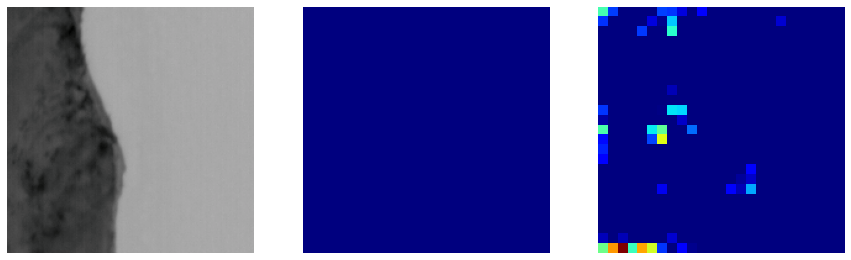

In [41]:
#Inspecting predicted densities against images
index = 9
img = invTrans(images[index])
img = (np.moveaxis(img.numpy(), 0, -1) * 255).astype(np.uint8)
den = preds[index].detach().squeeze(0)
gt_den = densities[index]

f, axarr = plt.subplots(1, 3, figsize = (15, 10))
axarr[0].imshow(img)
axarr[1].imshow(gt_den, cmap = CM.jet)
axarr[2].imshow(den, cmap = CM.jet)
for a in axarr:
    a.axis('off')

In [39]:
#Checking counts
print(f'We predicted {int(den.sum())} birds and there are actually {counts[index]} birds in this image')

We predicted 3 birds and there are actually 0 birds in this image


## Model testing

In [ ]:
#Loading the model
save_name = 'ASPDNet_70_epochs_6.23.2021.pth'
model = ASPDNet()
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'ASPDNet', save_name)))
pl_model = ASPDNetLightning(model = model, lr = HYPERPARAMETERS['learning_rate'])

In [53]:
#ALTERNATIVE: load the model using a PyTorch Lightning checkpoint
save_name = 'ASPDNet_no_neg_densities_200_epochs_7.7.2021.ckpt'
model = ASPDNet()
pl_model = ASPDNetLightning.load_from_checkpoint(os.path.join(MODEL_SAVE_FP, 'ASPDNet', save_name), model = model, lr = HYPERPARAMETERS['learning_rate'])

In [54]:
#Using the saved model and the test set to evaluate
trainer = Trainer(gpus = 1)
results = trainer.test(pl_model, test_dataloaders = dataloader_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test_MAE': 166.2603302001953,
 'Test_MPE': 0.08847565406505314,
 'Test_RMSE': 280.60405342609585}
--------------------------------------------------------------------------------
